In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [35]:
import sys
sys.path.append('../code_base')  # Only if not installed as a package

from model_suite.dataloader import generate_dataloader

from model_suite import training 
from model_suite.training import get_loss, train_loop
from model_suite.architectures import get_model
from model_suite.evaluation_metrics import cal_classification_metrics

from model_suite.utils.inference_utils import generate_saliency_map, load_saved_model, pred_degradation_category
from model_suite.utils.common import load_config, visualize_confusion_matrix
from model_suite.utils.preprocessing import load_image

In [3]:
torch.cuda.empty_cache()

# Training

In [4]:
config_path = "../configs/classification.yaml"
config = load_config(config_path)
pprint(config)

{'data_loader': {'batch_size': 1, 'num_workers': 2, 'shuffle': True},
 'dataset_loc': {'dataset_type': 'classification',
                 'train': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/train.csv',
                           'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
                           'random_subset': None},
                 'val': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/val.csv',
                         'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
                         'random_subset': None}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 3},
 'results_loc': './experiment_results/',
 'training': {'learning_rate': 0.05,
              'loss_fn_name': 'CrossEntropy',
              'num_epochs': 10,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 5}}


In [5]:
# # copy paste config here to edit and experiment
config={
  'data_loader': {
    'batch_size': 1,
    'num_workers': 2,
    'shuffle': True
  },
    
  'dataset_loc': {
    'dataset_type': 'classification',
    'train': {
      'degradation_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v5/degradation_segment_labels_train.csv',
      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v5/train/',
      'random_subset': None
    },
    'val': {
      'degradation_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v5/degradation_segment_labels_val.csv',
      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v5/val/',
      'random_subset': None
    }
  },
  'enable_cuda': True,
    
  'model': {
    'in_channels': 3,
    'out_dim': 3
  },
    
  'results_loc': '../experiment_results/',
    
  'training': {
    'learning_rate': 0.05,
    'loss_fn_name': 'CrossEntropy',
    'num_epochs': 5,
    'resume_checkpoint': None,
    'save_checkpoint_freq': 5
  }
}

In [6]:
# get required config parameters
model_config = config["model"]
dataset_config = config["dataset_loc"]
dataloader_config = config["data_loader"]
preprocess_config = config.get("dataset_preprocessing", None)
train_config = config["training"]

In [7]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = training.DEVICE
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [8]:
# update img trasnform if required

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.ToTensor()                    # Convert the image to a tensor
])

# generate train data loader
train_loader, train_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                               data_loc=dataset_config["train"],
                                               dataloader_config=dataloader_config,
                                               preprocess_config=preprocess_config)

# generate validation data loader
val_loader, val_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                           data_loc=dataset_config["val"],
                                           dataloader_config=dataloader_config,
                                           preprocess_config=preprocess_config)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 1235
Validation Dataset loaded. #samples: 253


Image batch shape: torch.Size([1, 3, 194, 273])
Degradation label shape: torch.Size([1, 3])
Degradation target: tensor([1., 0., 0.])


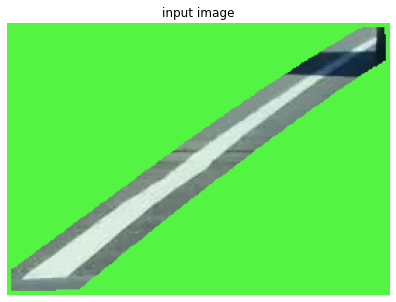

In [9]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", degradation_values.shape) 
print("Degradation target:", degradation_values[0])

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")
ax.axis("off")
plt.show()

In [10]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, **model_config)
model = model.to(training.DEVICE)

## fetch loss function as set in config
# criterion = get_loss(train_config["loss_fn_name"])

## OR add your own loss fucntion like shown below
# from model_suite.focal_loss import FocalLoss
# num_classes = 3
# alpha = [1.0, 1.2, 1.2]  # Example class weights
# criterion = FocalLoss(gamma=2, alpha=alpha, task_type='multi-class', num_classes=num_classes)
criterion = nn.CrossEntropyLoss()

# initialized optimizer as required
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))
    print("Model checkpoint loaded.")

In [11]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"])

Training Started...


Epoch: 1 val - : 100%|██████████| 253/253 [00:02<00:00, 124.27it/s]


Epoch [1/5], Train Loss: 2.4837, Val Loss: 1.0638, Epoch execution time: 0.44 min


Epoch: 2 val - : 100%|██████████| 253/253 [00:01<00:00, 146.36it/s]


Epoch [2/5], Train Loss: 1.0472, Val Loss: 1.0906, Epoch execution time: 0.16 min


Epoch: 3 val - : 100%|██████████| 253/253 [00:01<00:00, 145.01it/s]


Epoch [3/5], Train Loss: 1.0536, Val Loss: 1.1024, Epoch execution time: 0.18 min


Epoch: 4 val - : 100%|██████████| 253/253 [00:01<00:00, 130.16it/s]


Epoch [4/5], Train Loss: 1.0515, Val Loss: 1.0692, Epoch execution time: 0.17 min


Epoch: 5 val - : 100%|██████████| 253/253 [00:01<00:00, 147.56it/s]


Epoch [5/5], Train Loss: 1.0479, Val Loss: 1.0679, Epoch execution time: 0.17 min
   Learning curve saved to ../experiment_results/train_log/learning_curve_2025-04-15_06-56-23.png
   Learning history saved to ../experiment_results/train_log/learning_history_2025-04-15_06-56-23.json
Model saved at: ../experiment_results/checkpoints/unet_final_2025-04-15_06-56-23.pth
Training Completed! Total time: 1.1272 min


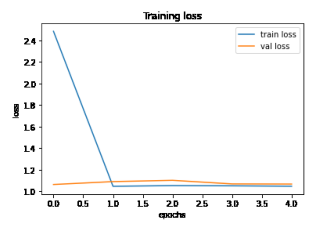

In [12]:
# open saved learning curve
plot_saved_path = "../experiment_results/train_log/learning_curve_2025-04-15_06-56-23.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [13]:
# Evaluate model performance at end of training using different losses
train_metrics, train_cm = cal_classification_metrics(model, train_loader, device=DEVICE)
val_metrics, val_cm = cal_classification_metrics(model, val_loader, device=DEVICE)

100%|██████████| 253/253 [00:00<00:00, 324.52it/s]


In [14]:
stats = pd.DataFrame([train_metrics, val_metrics], index=["train", "val"]).T
display(stats)

,train,val
accuracy,0.5012,0.4901
precision,0.2512,0.2402
recall,0.5012,0.4901
f1,0.3347,0.3224


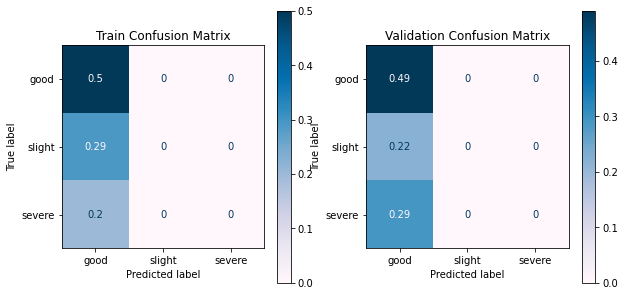

In [15]:
visualize_confusion_matrix(train_cm=train_cm, val_cm=val_cm, label_names=["good", "slight", "severe"])

## Saliency map

In [16]:
csv_path = dataset_config["val"]["degradation_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)
df.head(3)

,name,degradation_target
0,c9d61a6d-986df2e9_3.png,0
1,c9d61a6d-986df2e9_5.png,0
2,c9d61a6d-986df2e9_6.png,2


In [17]:
row = df.sample(1)
img_name, label = row["name"].values[0], row["degradation_target"].values[0]
p = os.path.join(dir_path, img_name)
img = load_image(p)

target class 0
Predicted Class 0


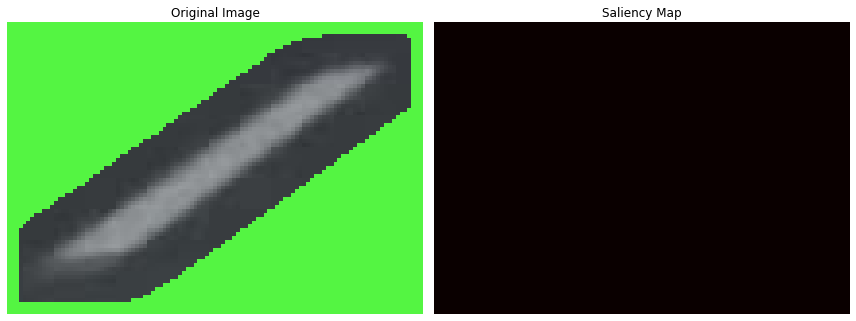

In [18]:
# Generate saliency map
print("target class", label)
saliency = generate_saliency_map(model, img, device=training.DEVICE)

# Plot the saliency map
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(img[:, :, :3])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(saliency, cmap='hot')
axes[1].set_title('Saliency Map')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Inference

In [25]:
saved_weight_path = "../experiment_results/checkpoints/unet_final_2025-04-15_06-56-23.pth"

In [29]:
model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 3}

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [31]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [32]:
csv_path = dataset_config["val"]["degradation_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)

row = df.sample(1)
test_img_name, label = row["name"].values[0], row["degradation_target"].values[0]
test_img_path = os.path.join(dir_path, test_img_name)
test_img = load_image(test_img_path)

Test image name: be3b7c5d-d25131a7_3.png
Test image shape: (129, 131, 3)


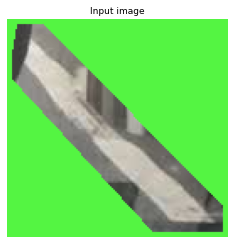

In [34]:
print("Test image name:", test_img_name)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [37]:
pred_class = pred_degradation_category(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation category:", pred_class)

Predicticted degradation category: 0
